# Task B: BiLSTM Model - Hyperparameter Tuning and Training of Model
This notebook performs hyperparameter tuning to identify the optimal configuration, retrains the model using the best hyperparameters, and saves the final trained model.



# Installing Required Packages

In [ ]:
!pip install nltk
!pip install keras-tuner
!pip install gensim

# Data Loading and NLTK Setup
Loading in training and development dataset for training & validation and downloading neccesary nltk packages for preprocessing.

In [ ]:
import nltk
import pandas as pd
nltk.download('punkt_tab')
nltk.download('wordnet')

df_train = pd.read_csv('/content/train.csv')
df_dev = pd.read_csv('/content/dev.csv')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Text Preprocessing for Premises and Hypotheses

This step cleans the text data for both the premise and hypothesis columns in the dataset.

## Preprocessing Pipeline Includes:
- Lowercasing the text
- Removing non-alphabetic characters
- Tokenising using NLTK's word_tokenize
- Lemmatising using WordNetLemmatizer

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
import re

lemmatizer = WordNetLemmatizer()

#Preprocess the data
def preprocessing(texts):
    preprocessed_texts = []

    for text in texts:
        if not text:  #handle empty text
            continue

        #clean the text: lowercase, strip whitespace, and remove non-alphabetic characters
        cleaned_text = re.sub(r'[^A-Za-z\s]', '', text.lower().strip())

        #tokenise the cleaned text
        tokenized_words = [word for word in word_tokenize(cleaned_text)]

        lemmatized_words = [lemmatizer.lemmatize(word) for word in tokenized_words]

        #append the lemmatized words to the list
        preprocessed_texts.append(lemmatized_words)

    return preprocessed_texts

premise_train = preprocessing(df_train['premise'])
hypothesis_train = preprocessing(df_train['hypothesis'])
labels_train = df_train['label'].values

premise_dev = preprocessing(df_dev['premise'])
hypothesis_dev = preprocessing(df_dev['hypothesis'])
label_dev = df_dev['label'].values

print("Processed Premise:", premise_train[:5])
print("Processed Hypothesis:", hypothesis_train[:5])

Processed Premise: [['yeah', 'i', 'dont', 'know', 'cut', 'california', 'in', 'half', 'or', 'something'], ['actual', 'name', 'will', 'not', 'be', 'used'], ['the', 'film', 'wa', 'directed', 'by', 'randall', 'wallace'], ['how', 'dyou', 'know', 'hell', 'sign', 'me', 'onanse', 'studied', 'his', 'own', 'unkempt', 'if', 'now', 'clean', 'reflection', 'in', 'the', 'shaving', 'mirror', 'on', 'the', 'wall'], ['in', 'the', 'light', 'of', 'the', 'candle', 'his', 'cheek', 'looked', 'even', 'more', 'hollow', 'tonight', 'and', 'he', 'moved', 'stiffly', 'a', 'might', 'a', 'man', 'who', 'wa', 'not', 'only', 'bonetired', 'in', 'body', 'thought', 'drew', 'but', 'weary', 'in', 'mind', 'a', 'well']]
Processed Hypothesis: [['yeah', 'im', 'not', 'sure', 'how', 'to', 'make', 'that', 'fit', 'maybe', 'you', 'could', 'cut', 'california', 'in', 'half', 'or', 'just', 'resize', 'it', 'to', 'make', 'it', 'fit'], ['for', 'the', 'sake', 'of', 'privacy', 'actual', 'name', 'are', 'not', 'used'], ['the', 'film', 'wa', 'di

#Prepare Training Data for LSTM Model¶
In this step, the preprocessed premise and hypothesis texts are converted into padded sequences of integers,  a format suitable for input into an LSTM-based model.

##What This Step Does:
###Tokenisation
- We initialize a Tokenizer from TensorFlow and fit it on the combined premise_train and hypothesis_train data.
- This maps each unique word to a unique integer.
- The tokenised texts are then converted into sequences of integers.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#initialize the tokenizer
tokenizer = Tokenizer()

tokenizer.fit_on_texts(premise_train + hypothesis_train)

premise_dev_seq = tokenizer.texts_to_sequences(premise_dev)
hypothesis_dev_seq = tokenizer.texts_to_sequences(hypothesis_dev)

premise_train_seq = tokenizer.texts_to_sequences(premise_train)
hypothesis_train_seq = tokenizer.texts_to_sequences(hypothesis_train)

premise_dev_seq = tokenizer.texts_to_sequences(premise_dev)
hypothesis_dev_seq = tokenizer.texts_to_sequences(hypothesis_dev)

###Padding Sequences
- To ensure uniform input shape, we calculate the maximum sequence length across all sequences.
- We then use pad_sequences to pad each sequence to this length using 'post' padding.

In [ ]:
max_len = max(max(len(seq) for seq in premise_train_seq + hypothesis_train_seq),
              max(len(seq) for seq in premise_dev_seq + hypothesis_dev_seq))

premise_train_pad = pad_sequences(premise_train_seq, maxlen=max_len, padding='post')
hypothesis_train_pad = pad_sequences(hypothesis_train_seq, maxlen=max_len, padding='post')

premise_dev_pad = pad_sequences(premise_dev_seq, maxlen=max_len, padding='post')
hypothesis_dev_pad = pad_sequences(hypothesis_dev_seq, maxlen=max_len, padding='post')

# Saving the Tokenizer and Sequence Length

To ensure consistent preprocessing between training and evaluation/testing phases, we save the fitted tokenizer and record the maximum sequence length (max_len) used for padding.

In [ ]:
import pickle

#save the tokenizer to a file
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Max Length:", max_len)

Max Length: 281


# Load Pretrained Word2Vec Embeddings
In this step, we enhance the model’s performance by initialising the embedding layer with pretrained Word2Vec embeddings from the Google News corpus.

###Why Use Pretrained Embeddings?
- Word2Vec captures rich semantic relationships between words based on their context in large corpora.
- Using pretrained vectors can improve model generalisation, especially with smaller size of training data.

In [ ]:
from gensim.models import KeyedVectors
import gensim.downloader as api
#load Pretrained Word2Vec (Google News)
word2vec = api.load("word2vec-google-news-300")
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))



#Set Random Seed for Reproducibility
To ensure consistent and reproducible results across different runs, we set random seeds for all key libraries used in this notebook.

In [ ]:
import tensorflow as tf
import random

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

#Build and Tune a BiLSTM-Attention Model for NLI¶
This step defines and tunes a neural network model for Natural Language Inference (NLI), using a combination of Bidirectional LSTMs, shared attention, interaction features, and hyperparameter tuning via Keras Tuner.

##Model Architecture Overview
The model takes two inputs: a premise and a hypothesis, both padded sequences of token indices. It uses pretrained Word2Vec embeddings and passes both inputs through parallel processing pipelines with shared configurations.

###Key Components:
- Embedding Layer:
Loads pretrained Word2Vec embeddings. This layer is frozen (trainable=False) to retain semantic knowledge from the external corpus.

- Stacked Bidirectional LSTMs:
Each input (premise and hypothesis) passes through two layers of BiLSTMs to capture contextual dependencies in both directions.

- Shared Attention:
Implements bidirectional attention between the premise and hypothesis — each attends to the other to focus on relevant parts of the counterpart sequence.

- GlobalAveragePooling + LayerNormalization:
The attention outputs are averaged and normalized for stable and dimension-reduced representations.

- Interaction Layer:
Combines pooled representations using:

  - Concatenation
  - Element-wise absolute difference
  - Element-wise multiplication
- Fully Connected Classifier:
Two dense layers (with relu activation, dropout, and LayerNorm) feed into a final sigmoid output for binary classification.

###Hyperparameter Tuning with Keras Tuner
To optimise the model, we use Keras Tuner’s RandomSearch strategy, which explores multiple configurations of key hyperparameters:

###Tuned Hyperparameters:
- dropout_rate: [0.3, 0.4] – dropout regularization applied throughout the model
- units: [32, 64] – number of units in each LSTM layer
- learning_rate: [1e-3, 1e-4] – learning rate for the Adam optimizer

###Early Stopping:
- To prevent overfitting and reduce unnecessary computation, we apply early stopping.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Bidirectional, Dropout, LayerNormalization, Subtract, Multiply, Attention, GlobalAveragePooling1D, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import keras_tuner as kt

def abs_diff(x):
    return K.abs(x)

def build_model(hp):
    #tunable hyperparameters
    DROPOUT_RATE = hp.Choice('dropout_rate', [0.3, 0.4])
    UNITS = hp.Choice('units', [32, 64])
    LEARNING_RATE = hp.Choice('learning_rate', [1e-3, 1e-4])

    premise_input = Input(shape=(max_len,))
    hypothesis_input = Input(shape=(max_len,))

    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False
    )

    premise_embed = Dropout(DROPOUT_RATE)(embedding_layer(premise_input))
    hypothesis_embed = Dropout(DROPOUT_RATE)(embedding_layer(hypothesis_input))

    #BiLSTM for premise
    premise_lstm = Bidirectional(LSTM(UNITS, return_sequences=True))(premise_embed)
    premise_lstm = Dropout(DROPOUT_RATE)(premise_lstm)
    premise_lstm = Bidirectional(LSTM(UNITS, return_sequences=True))(premise_lstm)
    premise_lstm = Dropout(DROPOUT_RATE)(premise_lstm)
    premise_lstm = LayerNormalization()(premise_lstm)

    #BiLSTM for hypothesis
    hypothesis_lstm = Bidirectional(LSTM(UNITS, return_sequences=True))(hypothesis_embed)
    hypothesis_lstm = Dropout(DROPOUT_RATE)(hypothesis_lstm)
    hypothesis_lstm = Bidirectional(LSTM(UNITS, return_sequences=True))(hypothesis_lstm)
    hypothesis_lstm = Dropout(DROPOUT_RATE)(hypothesis_lstm)
    hypothesis_lstm = LayerNormalization()(hypothesis_lstm)

    # Shared attention
    attention = Attention()
    attended_premise = attention([hypothesis_lstm, premise_lstm])
    attended_hypothesis = attention([premise_lstm, hypothesis_lstm])

    # Pooling
    pooled_premise = GlobalAveragePooling1D()(attended_premise)
    pooled_premise = LayerNormalization()(pooled_premise)

    pooled_hypothesis = GlobalAveragePooling1D()(attended_hypothesis)
    pooled_hypothesis = LayerNormalization()(pooled_hypothesis)

    #interaction (Local Inference) layer
    diff = Lambda(abs_diff)(Subtract()([pooled_premise, pooled_hypothesis]))
    mul = Multiply()([pooled_premise, pooled_hypothesis])
    merged = Concatenate()([pooled_premise, pooled_hypothesis, diff, mul])
    merged = LayerNormalization()(merged)

    #dense classifier
    dense = Dense(64, activation='relu', kernel_regularizer='l2')(merged)
    dense = Dropout(DROPOUT_RATE)(dense)
    dense = LayerNormalization()(dense)

    dense = Dense(32, activation='relu', kernel_regularizer='l2')(dense)
    dense = Dropout(DROPOUT_RATE)(dense)
    dense = LayerNormalization()(dense)

    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[premise_input, hypothesis_input], outputs=output)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=LEARNING_RATE),
        metrics=['accuracy']
    )
    return model

#EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#tuner setup
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='tuner_results',
    project_name='nli_attention_bilstm',
    overwrite=True
)

#search
tuner.search(
    [premise_train_pad, hypothesis_train_pad],
    labels_train,
    validation_data=([premise_dev_pad, hypothesis_dev_pad], label_dev),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

tuner.results_summary()


Trial 7 Complete [00h 39m 35s]
val_accuracy: 0.6717636585235596

Best val_accuracy So Far: 0.6769596338272095
Total elapsed time: 03h 04m 10s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Results summary
Results in tuner_results/nli_attention_bilstm
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
dropout_rate: 0.3
units: 32
learning_rate: 0.001
Score: 0.6769596338272095

Trial 02 summary
Hyperparameters:
dropout_rate: 0.3
units: 64
learning_rate: 0.001
Score: 0.6744358539581299

Trial 01 summary
Hyperparameters:
dropout_rate: 0.4
units: 32
learning_rate: 0.0001
Score: 0.6728028655052185

Trial 06 summary
Hyperparameters:
dropout_rate: 0.4
units: 64
learning_rate: 0.0001
Score: 0.6717636585235596

Trial 05 summary
Hyperparameters:
dropout_rate: 0.3
units: 64
learning_rate: 0.0001
Score: 0.666419267654419

Trial 03 summary
Hyperparameters:
dropout_rate: 0.4
units: 32
learning_rate: 0.001
Score: 0.5651721954345703

Trial 00 summary
Hyperparameters:
dropout_rate: 0.4
units: 64
learning_rate: 0.001
Score: 0.5163301825523376


# Retrieve the Best Hyperparameters
After completing the hyperparameter search using Keras Tuner, we now retrieve the best-performing hyperparameter combination and use it to retrain the model architecture.

In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
for param in best_hp.values:
    print(f"{param}: {best_hp.get(param)}")


dropout_rate: 0.3
units: 32
learning_rate: 0.001


 # Model Training with Best Hyperparameters

After identifying the best hyperparameters from the tuning phase, we rebuild and retrain the model using the full training and validation setup.

In [ ]:
#rebuild the model using best hyperparams
model = build_model(best_hp)

#retrain the model
history = model.fit(
    [premise_train_pad, hypothesis_train_pad],
    labels_train,
    validation_data=([premise_dev_pad, hypothesis_dev_pad], label_dev),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

#save the trained model
model.save("best_nli_model_B.keras")


Epoch 1/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 85s 98ms/step - accuracy: 0.5161 - loss: 1.3994 - val_accuracy: 0.6137 - val_loss: 0.6926
Epoch 2/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 81s 97ms/step - accuracy: 0.6076 - loss: 0.6895 - val_accuracy: 0.6545 - val_loss: 0.6438
Epoch 3/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 78s 102ms/step - accuracy: 0.6254 - loss: 0.6615 - val_accuracy: 0.6444 - val_loss: 0.6535
Epoch 4/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 81s 101ms/step - accuracy: 0.6434 - loss: 0.6502 - val_accuracy: 0.6442 - val_loss: 0.6447
Epoch 5/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 83s 102ms/step - accuracy: 0.6469 - loss: 0.6394 - val_accuracy: 0.6547 - val_loss: 0.6444
Epoch 6/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 78s 97ms/step - accuracy: 0.6498 - loss: 0.6429 - val_accuracy: 0.6666 - val_loss: 0.6470
Epoch 7/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 86s 102ms/step - accuracy: 0.6656 - loss: 0.6318 - val_accuracy: 0.6617 - val_loss: 0.6197
Epoch 8/50
764/764 ━━━━━━━━━━━━━━━━━━━━ 81s 101ms/step - accuracy: 0.6672 - loss: 0.62

#Visualise Training Curves & Evaluate Final Model
Once the model is retrained using the best hyperparameters, we proceed to visualise its training performance and evaluate it on the development set.

##Training and Validation Curves
The function plot_training_curves(history) plots:

- Training vs Validation Accuracy
- Training vs Validation Loss

These plots help us understand how well the model learned over epochs, whether there is overfitting or underfitting and when early stopping might have kicked in.

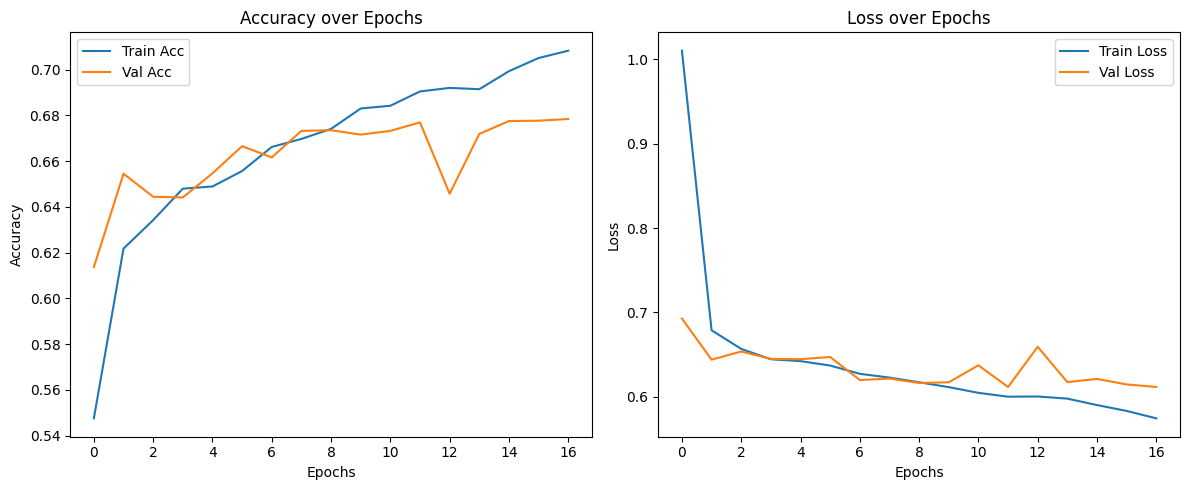

211/211 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6646 - loss: 0.6219
Final Dev Accuracy: 0.6770
Final Dev Loss    : 0.6114


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

#plot training & validation accuracy/loss
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    #accuracy graph
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    #loss graph
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('BiLSTM_graph.png')
    plt.show()

plot_training_curves(history)

#evaluating the final performance
loss, acc = model.evaluate([premise_dev_pad, hypothesis_dev_pad], label_dev)
print(f"Final Dev Accuracy: {acc:.4f}")
print(f"Final Dev Loss    : {loss:.4f}")